# Gaussian Fitting for S I Lines
Now that we have extracted just the sulfur I lines from the .csv file, we can take a closer look at the brightness and measure it using the [Markov chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) method. Let us begin by plotting the spectrum and zooming in on the first S I line.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
#%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
hdulist = fits.open('../data/composite_Io_eclipsed.fits')
evt_data = Table(hdulist[1].data)
image_data = hdulist[1].data

In [3]:
df = pd.read_csv('../data/Io_Master_Line_List (1).csv') #spaces in csv file will make df object type and not float64
line = "S I"
target_mask = df.Species.str.endswith(line) #probably a better function but idk it right now
df = df[target_mask]
df_wavelength = df['Wavelength']
df_species = df['Species']

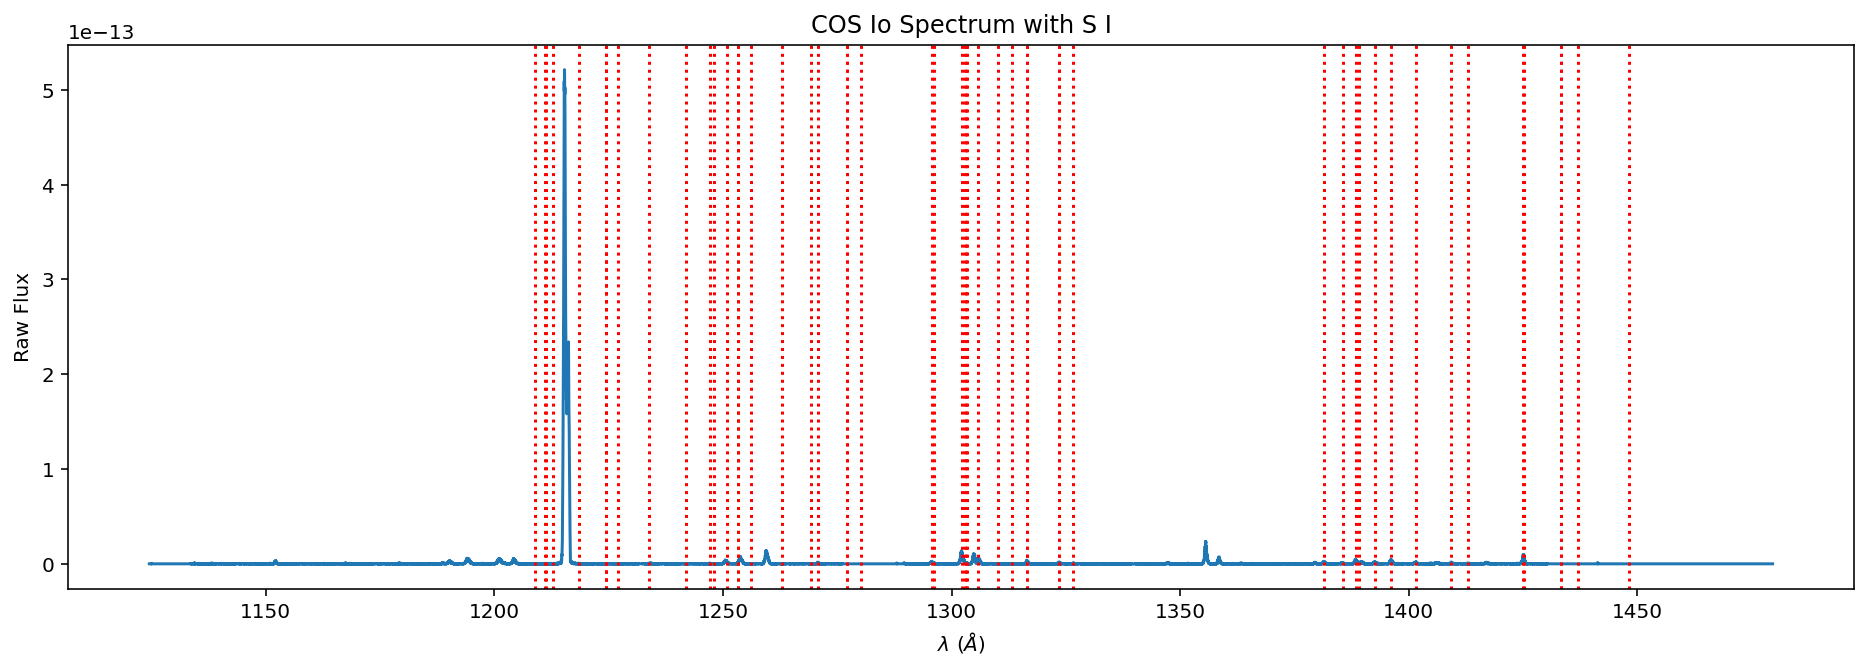

In [4]:
plt.figure(figsize=(16, 5))
plt.plot(evt_data['WAVELENGTH'].T, evt_data['FLUX'].T) #make it columns instead of rows bc otherwise will be a blank plot
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.title("COS Io Spectrum with S I")
for xc in df_wavelength:
    plt.axvline(x=xc, color = 'red', linestyle = 'dotted')

The first sulfur I line is given at 1208.8500 $\mathring A$. 

(-0.02, 0.1)

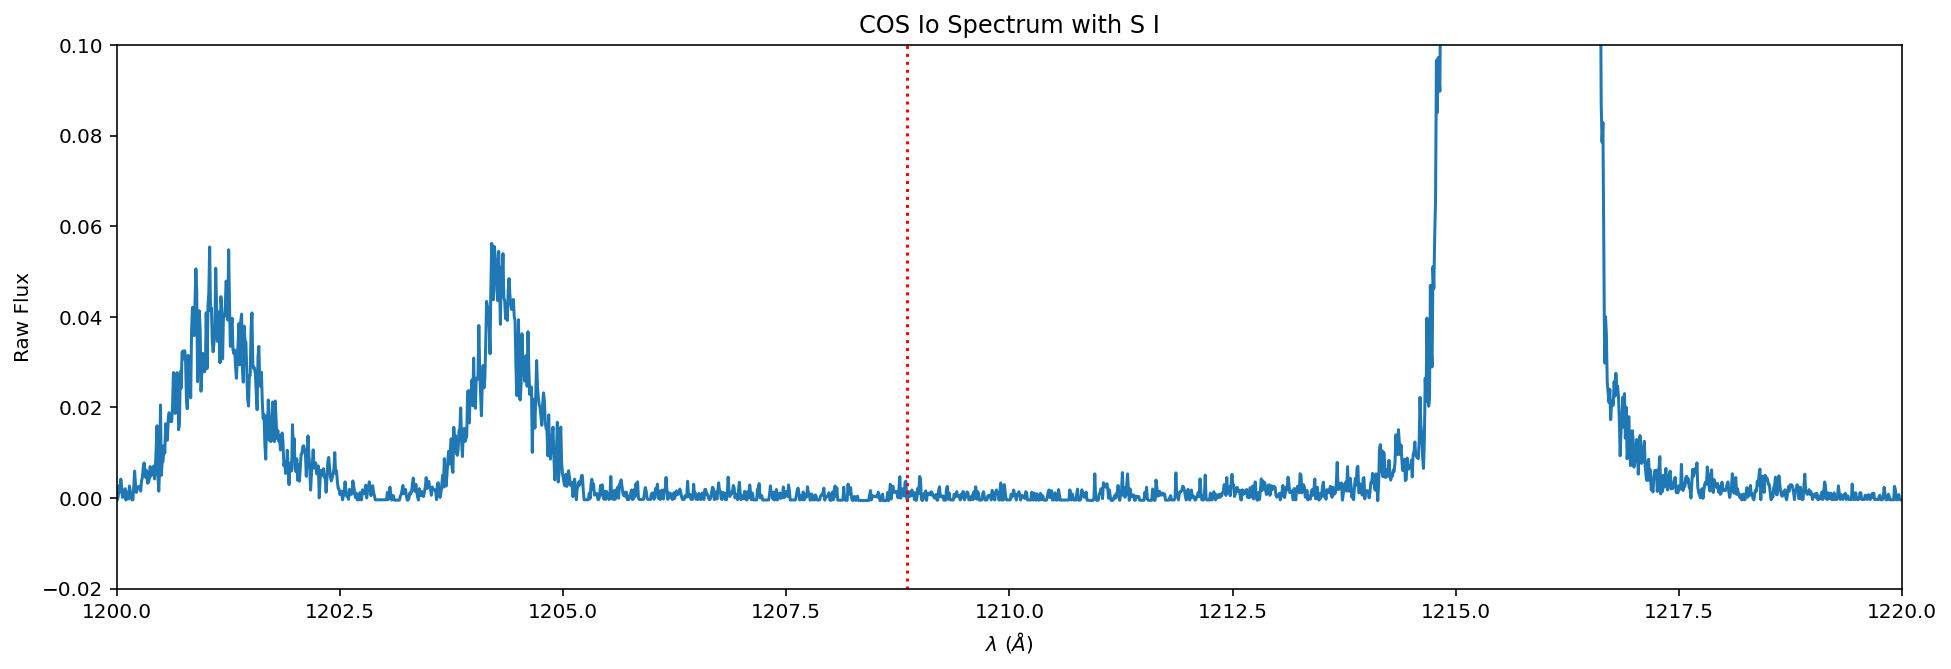

In [5]:
plt.figure(figsize=(16, 5))
plt.plot(evt_data['WAVELENGTH'].T, evt_data['FLUX'].T/10**-13) #make it columns instead of rows bc otherwise will be a blank plot
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.title("COS Io Spectrum with S I")
plt.axvline(1208.8500, color = 'red', linestyle = 'dotted')
plt.xlim(1200,1220)
plt.ylim(-0.02,0.1)

We don't really see much of a line here so let's continue to the next line.

(-0.005, 0.15)

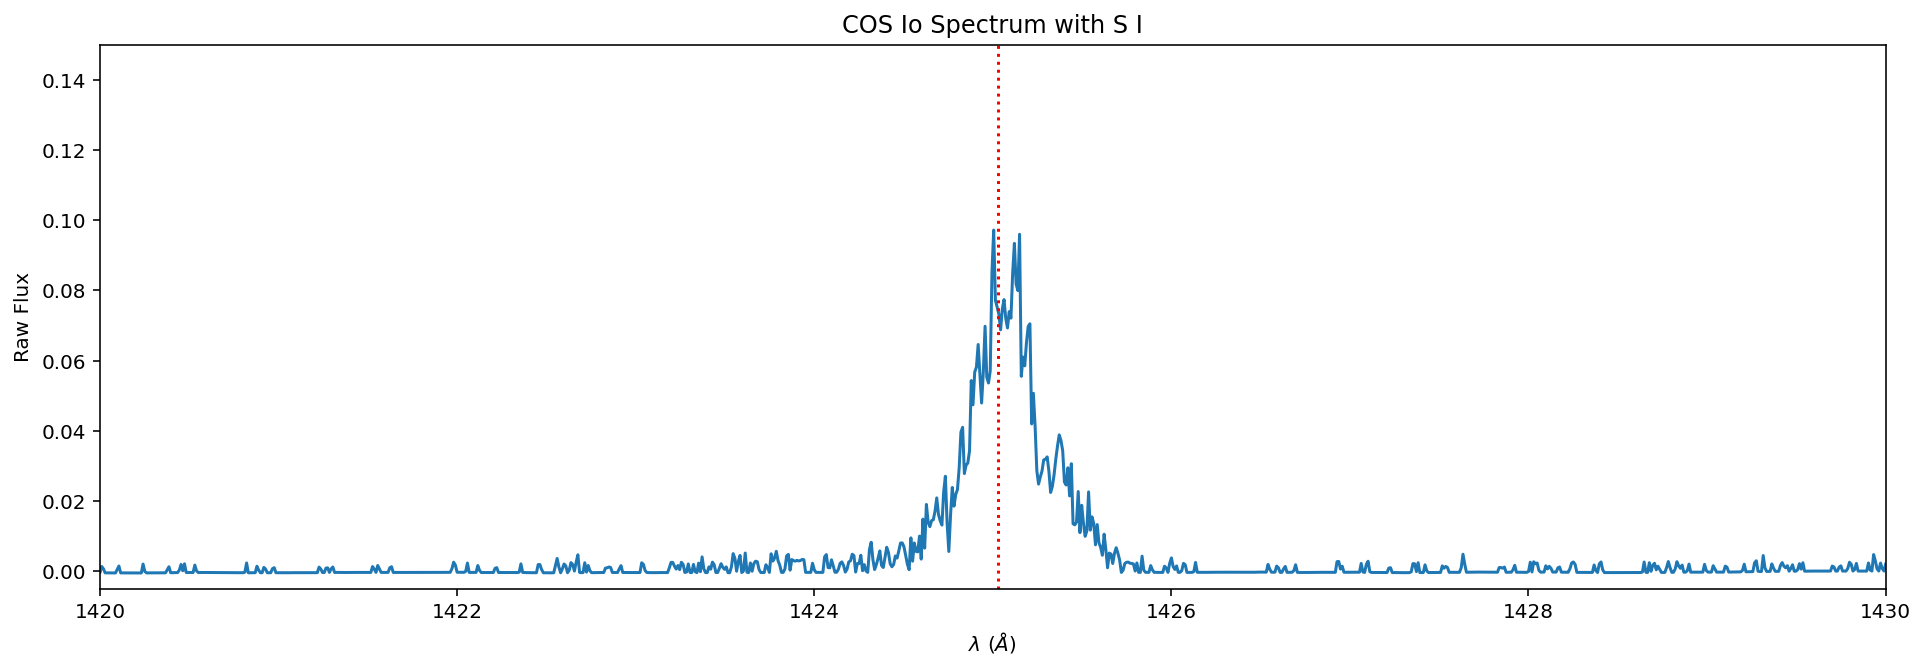

In [6]:
plt.figure(figsize=(16, 5))
plt.plot(evt_data['WAVELENGTH'].T, evt_data['FLUX'].T/10**-13) #make it columns instead of rows bc otherwise will be a blank plot
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.title("COS Io Spectrum with S I")
plt.axvline(1425.030, color = 'red', linestyle = 'dotted')
plt.xlim(1420,1430)
plt.ylim(-0.005,0.15)

Ok, let's fit a model to this data.  The model will consist of a straight-line trend with a Gaussian added to it.  It will have five parameters, the straight-line trend slope $m$ and offset $b$, and the Gaussian amplitude $A$, center wavelength $\mu$, and width $w$.  
$$f_\lambda(m, b, A, \mu, w)= m \lambda +b + A\cdot e^{-\frac{1}{2} \frac{(\lambda-\mu)^2}{w^2}}$$

Let's focus on the **sub-region** set by the above plot.
$$f_\lambda(m, b, A, \mu, w)= 1 + \frac{A}{(m \mu + b)}\cdot e^{-\frac{1}{2} \frac{(\lambda-\mu)^2}{w^2}}$$


We will start by setting the bounds for the gaussian to create this **sub-region**.

(-0.005, 0.15)

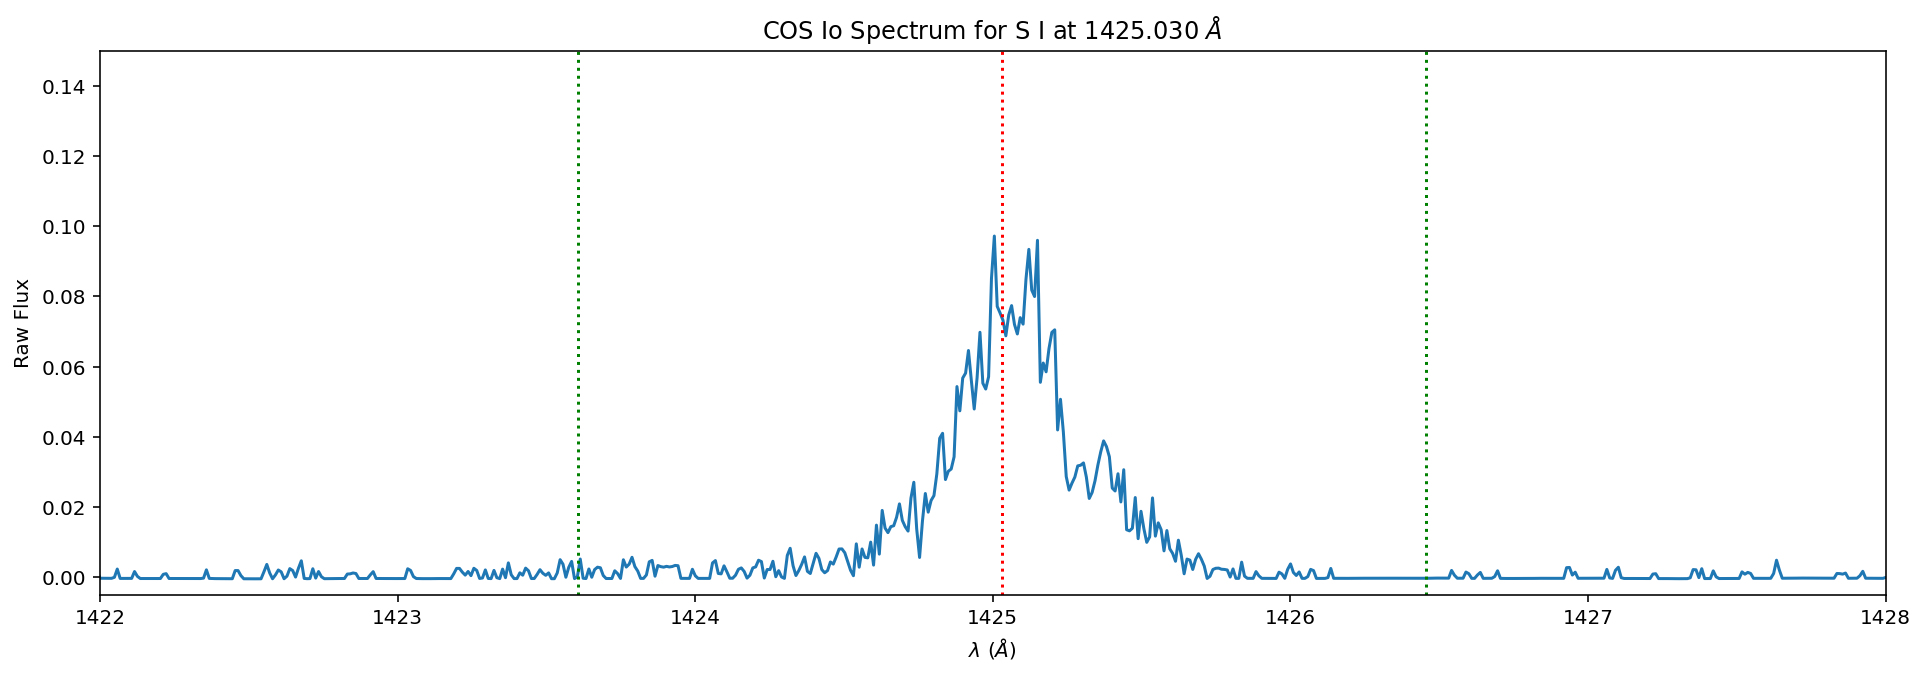

In [7]:
line = 1425.030
left_bound = 0.999*line
right_bound = 1.001*line
plt.figure(figsize=(16, 5))
plt.plot(evt_data['WAVELENGTH'].T, evt_data['FLUX'].T/10**-13) #make it columns instead of rows bc otherwise will be a blank plot
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.title("COS Io Spectrum for S I at 1425.030 $\AA$")
plt.axvline(line, color = 'red', linestyle = 'dotted')
plt.axvline(left_bound, color = 'green', linestyle = 'dotted')
plt.axvline(right_bound, color = 'green', linestyle = 'dotted')
plt.xlim(1422,1428)
plt.ylim(-0.005,0.15)

In [8]:
sub_region = (evt_data['WAVELENGTH'] > left_bound) & (evt_data['WAVELENGTH'] < right_bound)
wl = evt_data['WAVELENGTH'][sub_region]
flux = evt_data['FLUX'][sub_region]

In [9]:
def generative_model(m, b, A, mu, logw, int_wl = line):
    """Generate the model given parameters"""
    continuum = m * (wl - int_wl) + b
    w = np.exp(logw)
    gaussian = A * np.exp(-0.5*(wl-mu)**2/w**2)
    return continuum + gaussian

In [10]:
m_guess, b_guess, A_guess, mu_guess, logw_guess = 0.01, 0.3, 0.1, line, np.log(0.4)

In [11]:
flux_guess = generative_model(m_guess, b_guess, A_guess, mu_guess, logw_guess)

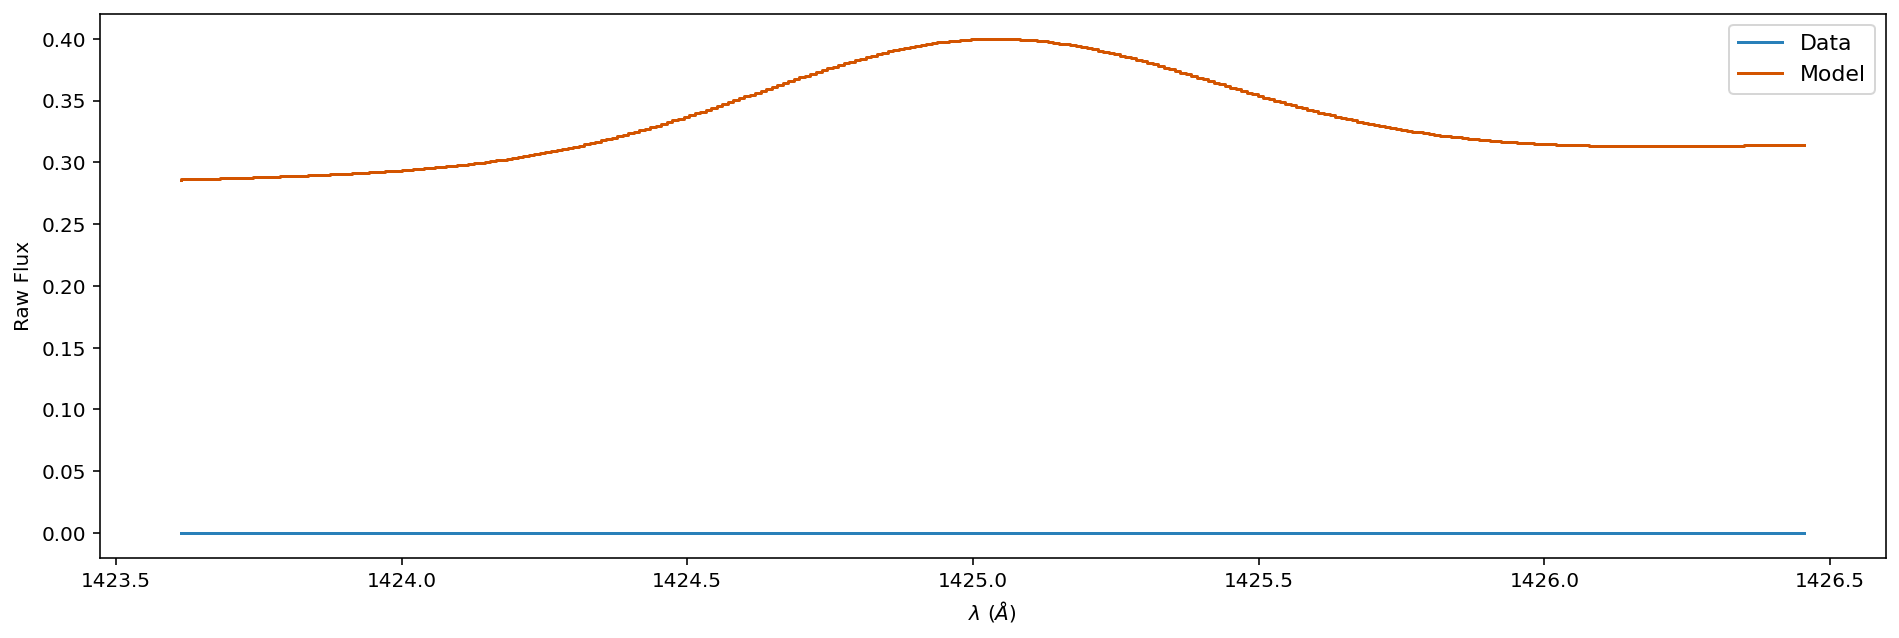

In [12]:
plt.figure(figsize=(16, 5))
plt.step(wl, flux, label='Data', color='#2980b9');
plt.step(wl, flux_guess, label='Model', color='#d35400');
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);
#plt.ylim(.9,1.3)

# Test

In [13]:
evt_data

FLUX [36739],WAVELENGTH [36739]
float64,float64
0.0 .. 0.0,1124.5707011882266 .. 1479.5615197001903


In [19]:
from astropy.table import Table
dat = Table.read('../data/composite_Io_eclipsed.fits', format='fits')
df_io = dat.to_pandas()

ValueError: Cannot convert a table with multidimensional columns to a pandas DataFrame. Offending columns are: ['FLUX', 'WAVELENGTH']
One can filter out such columns using:
names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
tbl[names].to_pandas(...)

In [20]:
df_io

NameError: name 'df_io' is not defined

In [ ]:
from astropy.table import Table
t = Table()
t['a'] = [1, 2, 3, 4]
t['b'] = ['a', 'b', 'c', 'd']
type(t)

In [ ]:
t

In [ ]:
df = t.to_pandas()
type(df)

In [ ]:
df_io = evt_data.to_pandas()

In [ ]:
evt_data

In [ ]:
w = evt_data['WAVELENGTH'].T
w

In [ ]:
df_io = w.to_pandas()

In [ ]:
type(w)